# Set up

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
# import bbknn
import re
import httplib2 as http
import json

In [2]:
sc.set_figure_params(facecolor="white", figsize=(5, 5), format = 'pdf',dpi_save=300,dpi=200)
sc.settings.verbosity = 'error'

In [3]:
def getHGNCgroup(
    GID, # HGNC group ID,
    sortby='name' # parameter to sort the output by, defaults to gene name
):
    # http request
    target = f'https://www.genenames.org/cgi-bin/genegroup/download?id={GID}&type=branch&format=json'
    method = 'GET'
    h = http.Http()
    response, content = h.request(target,method)
    # parses the JSON
    if response['status'] == '200':
        data = json.loads(content)
    else:
        print('Error detected: ' + response['status'])
    
    # makes lists for symbol, name, group name
    symbol = []
    name = []
    group_name = []
    hgnc = []

    # extracts these from the JSON

    for i in range(len(data)):
        symbol.append((data[i]['approvedSymbol']))
        name.append((data[i]['approvedName']))
        group_name.append((data[i]['groupName']))
        hgnc.append((data[i]['hgncID']))
        group_info = {
            'symbol':symbol,
            'name':name,
            'group_name':group_name,
            'hgnc':hgnc}
        group_info=pd.DataFrame.from_dict(group_info).sort_values(sortby,ascending=True)
    return group_info

In [4]:
def getHGNCgroup_dict(
    GID, # HGNC group ID,
):
    group_info=getHGNCgroup(GID)
    # make the list of keys
    l = []
    for x in group_info['group_name']:
        if x not in l:
            l.append(x)

    # make dictionary
    gene_dict = {} # make empty dictionary
    for k in l:
        gene_dict[k]=list(group_info[group_info['group_name']==k]['symbol'])

    # check genes are present in adata.raw
    for key in gene_dict.keys():
        gene_dict[key]=[x for x in gene_dict[key] if x in adata.raw.var_names]
    return gene_dict

In [5]:
# based on sctk.pseudo_bulk
# https://github.com/Teichlab/sctk/blob/c6d0c7b2ffe3243d83d743a3beb04680150cb6e7/sctk/_utils.py#L632
import scipy.sparse as sp

def get_exp_proportion(
        adata, groupby, use_rep='X'):
    """get proportion of expressing cells from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = np.sum(x[k_grp,:]>0,axis=0)/x[k_grp,:].shape[0]
        else:
            print('X is not sparce')
    return pd.DataFrame(summarised.T, columns=groups, index=features)

In [6]:
import pickle
# save
def save_pkl(obj, file):
    with open(file, "wb") as tf:
        pickle.dump(obj, tf)

# read
def read_pkl(file):
    with open(file, "rb") as tf:
        obj = pickle.load(tf)
    
    return obj

# Load data

In [7]:
adata = sc.read('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')
print(adata.X.data[:5])
print(adata.var.index[:5])

# set gene name as var_names 
adata.var['gene_id']=adata.var_names.copy()
adata.var.set_index('gene_name-new',inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

# normalised and log transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
print(adata.X.data[:5])
print(adata.var.index[:5])

# remove unclassified cells
adata=adata[adata.obs['cell_state']!='unclassified']

adata

[1. 1. 1. 1. 2.]
Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object')
[0.27016106 0.27016106 0.27016106 0.27016106 0.4826427 ]
Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object', name='gene_name-new')


View of AnnData object with n_obs × n_vars = 690558 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'gene_id'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor

# Subsetting

In [8]:
# keep only multiome (to make fair comparison for DE testing)
adata = adata[adata.obs['kit_10x']=='Multiome-v1']

# subset CMs only
adata = adata[adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]
adata.obs['cell_type'].value_counts()

Ventricular Cardiomyocyte    45979
Atrial Cardiomyocyte         19375
Name: cell_type, dtype: int64

In [9]:
adata.obs['kit_10x'].value_counts()

Multiome-v1    65354
Name: kit_10x, dtype: int64

In [10]:
adata

View of AnnData object with n_obs × n_vars = 65354 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'gene_id'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_

# Modify cell type group

In [11]:
#Add in cell_type_with_CCS_states
adata.obs['cell_type_with_CCS_states']=adata.obs['cell_type'].copy()
adata.obs['cell_type_with_CCS_states']=adata.obs['cell_type_with_CCS_states'].astype('str')

adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='SAN_P_cell']='SAN_P_cell'
adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_P_cell']='AVN_P_cell'
adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_bundle_cell']='AVN_bundle_cell'
adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='Purkinje_cell']='Purkinje_cell'

Trying to set attribute `.obs` of view, copying.
<ipython-input-11-f4b7695aa0cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='SAN_P_cell']='SAN_P_cell'
<ipython-input-11-f4b7695aa0cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_P_cell']='AVN_P_cell'
<ipython-input-11-f4b7695aa0cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [12]:
# chage catergorical variable order
adata.obs["cell_type_with_CCS_states"]=adata.obs["cell_type_with_CCS_states"].astype('category')
adata.obs["cell_type_with_CCS_states"].cat.reorder_categories(["SAN_P_cell","AVN_P_cell","AVN_bundle_cell","Purkinje_cell",'Atrial Cardiomyocyte','Ventricular Cardiomyocyte'], inplace=True)

In [13]:
adata.obs['cell_type_with_CCS_states'].value_counts()

Ventricular Cardiomyocyte    45952
Atrial Cardiomyocyte         18937
SAN_P_cell                     245
AVN_P_cell                     155
AVN_bundle_cell                 38
Purkinje_cell                   27
Name: cell_type_with_CCS_states, dtype: int64

# Extract DEG table for CCS cells

In [14]:
# filter genes based on the subsetted object
sc.pp.filter_genes(adata, min_cells=3)
adata.shape

(65354, 29288)

In [15]:
# Calculate DEG values
sc.tl.rank_genes_groups(adata,groupby='cell_type_with_CCS_states',reference='Atrial Cardiomyocyte',method='t-test')

cells=adata.obs.cell_type_with_CCS_states.unique().tolist()
cells.remove('Atrial Cardiomyocyte')
cells

# Get DEG df
DEG_df=sc.get.rank_genes_groups_df(adata,group=cells)
DEG_df.set_index('group',inplace=True)
DEG_df.to_csv('CCS_cell_DEGs.csv')

In [17]:
DEG_df[DEG_df['names']=='KCNJ3']

,names,scores,logfoldchanges,pvals,pvals_adj
group,,,,,
Ventricular Cardiomyocyte,KCNJ3,-242.918121,-5.818223,0.000000e+00,0.000000e+00
Purkinje_cell,KCNJ3,-19.306406,-3.985135,4.350615e-17,4.063164e-16
SAN_P_cell,KCNJ3,9.668917,0.848924,5.573965e-19,5.266139e-17
AVN_bundle_cell,KCNJ3,-9.783408,-2.044111,7.685972e-12,5.565062e-11
AVN_P_cell,KCNJ3,-5.513110,-0.679332,1.428235e-07,1.249407e-06


# Action Potential Plot

## Without TFs

In [18]:
markers = {
    'HCN channels':['HCN1','HCN4'],
    'Calcium channels':['CACNA1D','CACNA1G','CACNA2D2'],
    'Sodium channels':['SCN5A'],
    'Potassium channels':['KCNJ5','KCND2','KCNK13','KCNN2'], # 'KCNJ3',
        'Connexins':['GJA1','GJA5','GJC1']
}

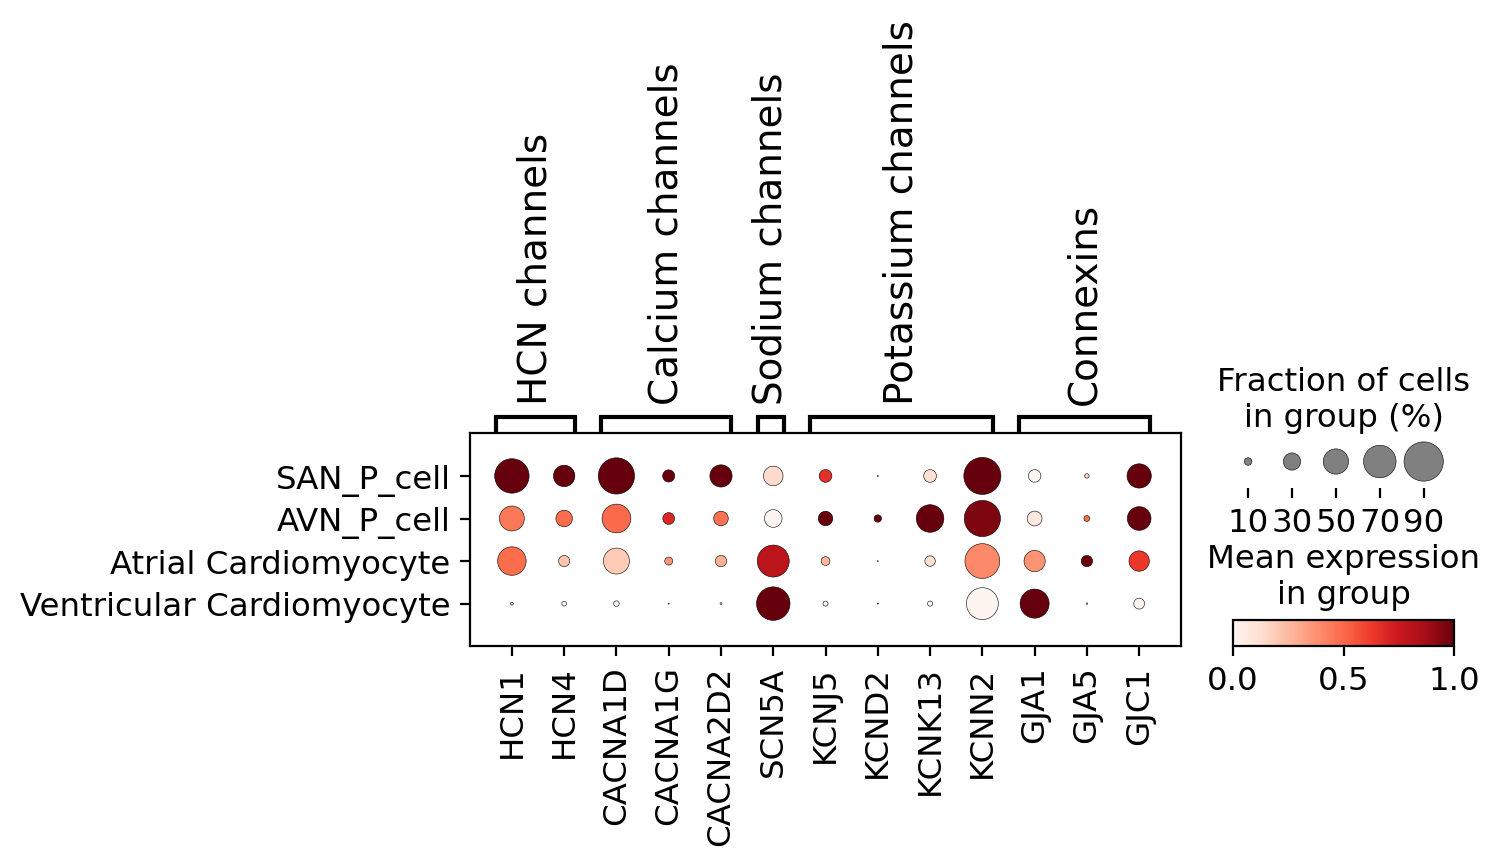

In [19]:
tmp=adata[adata.obs.cell_type_with_CCS_states.isin(["SAN_P_cell","AVN_P_cell",'Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]

dp=sc.pl.dotplot(tmp,
             groupby='cell_type_with_CCS_states',
             var_names=markers,
            standard_scale='var',
                save='Main3A_action_potential_dotplot_without_TFs.pdf')

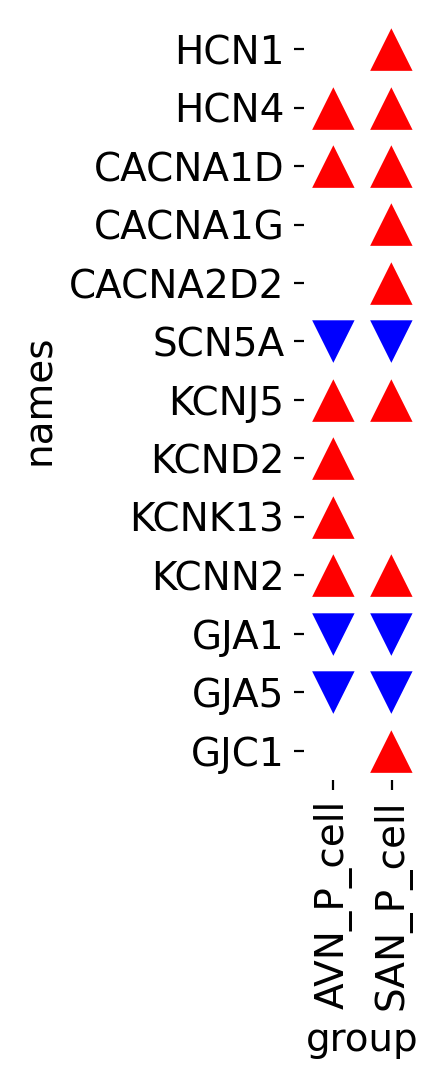

In [20]:
## Make arrow plot

# Calculate DEG values
# sc.tl.rank_genes_groups(tmp,groupby='cell_type_with_CCS_states',reference='Atrial Cardiomyocyte',method='t-test')

# Get DF, subsetting by just P cells
df = DEG_df.copy()
df.reset_index(inplace=True)
df=df[df['group'].isin(['AVN_P_cell','SAN_P_cell'])]
df=df[df.pvals_adj<0.05]
df=df.pivot(index='names',values='logfoldchanges',columns='group')
df=df[['AVN_P_cell','SAN_P_cell']]

import itertools
marker_genes=list(itertools.chain.from_iterable(markers.values()))
df=df[df.index.isin(marker_genes)] # Keep only genes of interest
df=df.reindex(marker_genes) # re-order index to match dotplot

# Plot arrows
import seaborn as sns

fig, (ax) = plt.subplots(ncols=1)

sns.heatmap(df,
           cmap='Greys',
           xticklabels=True,
           yticklabels=True,
           cbar=False,
           alpha=0,
           square=True)

for i, c in enumerate(df.columns):
    for j, v in enumerate(df[c]):
        if v > 0 :
            ax.text(i + 0.5, j + 0.5, '▲', color='red', size=20, ha='center', va='center')
        if v < 0 :
            ax.text(i + 0.5, j + 0.5, '▼', color='blue', size=20, ha='center', va='center')

plt.savefig('/home/jovyan/projects/P38_Adult-heart-RNA_celltype-annotation/notebooks/Revision/figures/Main3A_action_potential_arrows_without_TFs.pdf')
plt.show()

# Plot DEGs

In [48]:
DEG_df = DEG_df.reset_index()
DEG_df = DEG_df[DEG_df['group'].isin(["SAN_P_cell", "AVN_P_cell", "AVN_bundle_cell",'Purkinje_cell'])]

## Ion channels

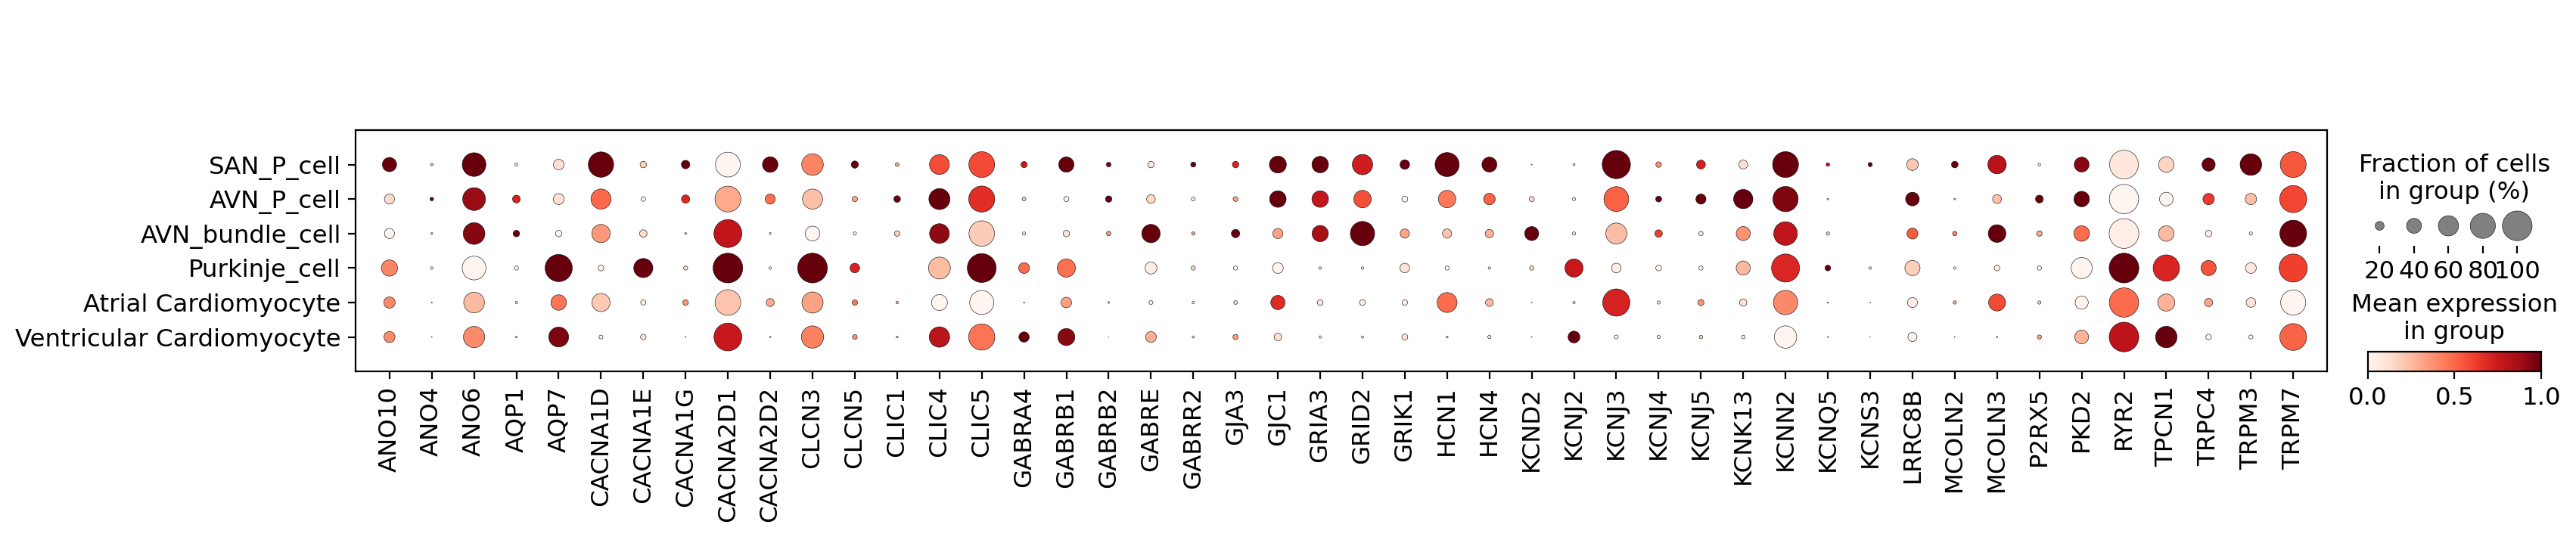

In [49]:
# Plot all DEGs from a HGNC class in one dotplot
genes_of_interest=getHGNCgroup(177).symbol.tolist()

genes_for_plotting=DEG_df[(DEG_df.names.isin(genes_of_interest))
       &(DEG_df.logfoldchanges>0)
       &(DEG_df.pvals_adj<0.05)].names.tolist()

genes_for_plotting=sorted(set(genes_for_plotting))

sc.pl.dotplot(adata,
             groupby='cell_type_with_CCS_states',
             var_names=genes_for_plotting,
             standard_scale='var')

In [50]:
len(genes_for_plotting)

46

In [53]:
# Make into dictionary for a organised plot with dict
ions = read_pkl("/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID177_Ion-channels_dict.pkl")
len(ions.keys())

# make a dictionary for group-genes
markers = {}
for k,v in ions.items():
    g =  [x for x in v if x in genes_for_plotting]
    if len(g) > 0:
        markers[k] = g
markers

{'Anoctamins': ['ANO10', 'ANO4', 'ANO6'],
 'Aquaporins': ['AQP1', 'AQP7'],
 'Chloride voltage-gated channels': ['CLCN3', 'CLCN5'],
 'Calcium voltage-gated channel auxiliary alpha2delta subunits': ['CACNA2D1',
  'CACNA2D2'],
 'Calcium voltage-gated channel alpha1 subunits': ['CACNA1D',
  'CACNA1E',
  'CACNA1G'],
 'Chloride intracellular channels': ['CLIC1', 'CLIC4', 'CLIC5'],
 'Cyclic nucleotide gated channels': ['HCN1', 'HCN4'],
 'Gamma-aminobutyric acid type A receptor subunits': ['GABRA4',
  'GABRB1',
  'GABRB2',
  'GABRE',
  'GABRR2'],
 'Gap junction proteins': ['GJA3', 'GJC1'],
 'Glutamate ionotropic receptor AMPA type subunits': ['GRIA3'],
 'Glutamate ionotropic receptor delta type subunits': ['GRID2'],
 'Glutamate ionotropic receptor kainate type subunits': ['GRIK1'],
 'Volume regulated anion channel subunits': ['LRRC8B'],
 'Transient receptor potential cation channels': ['MCOLN2',
  'MCOLN3',
  'PKD2',
  'TRPC4',
  'TRPM3',
  'TRPM7'],
 'Potassium calcium-activated channels': ['

In [54]:
# rearrange/rename groups based on the genes that appeared
groups_to_show = {
    'Cyclic nucleotide gated channels':'Pacemaker channels',
    'Calcium voltage-gated channel alpha1 subunits':'VG Calcium channels',
    'Calcium voltage-gated channel auxiliary alpha2delta subunits':'VG Calcium channels',
    'Potassium voltage-gated channels':'Potassium channels',
    'Potassium inwardly rectifying channel subfamily J':'Potassium channels',
    'Potassium two pore domain channel subfamily K ':'Potassium channels',
    'Potassium calcium-activated channels':'Potassium channels',
    'Chloride voltage-gated channels':'Chloride channels',
    'Chloride intracellular channels':'Chloride channels',
    'Chloride voltage-gated channels':'Chloride channels',
    'Transient receptor potential cation channels':'TRP Family',
    'Anoctamins':'Chloride channels',
    'Aquaporins':'Aquaporins',
    'Glutamate ionotropic receptor AMPA type subunits':'LGICs',
    'Glutamate ionotropic receptor delta type subunits':'LGICs',
    'Glutamate ionotropic receptor kainate type subunits':'LGICs',
    'Gap junction proteins':'Connexins',
    'Gamma-aminobutyric acid type A receptor subunits':'GABAA receptors',
    'Volume regulated anion channel subunits':'VRACs',
    'Purinergic receptors P2X':'Purinergic receptors',
    'Ryanodine receptors':'Ryanodine receptors',
    'Two pore segment channels':'Two-pore channels'
}

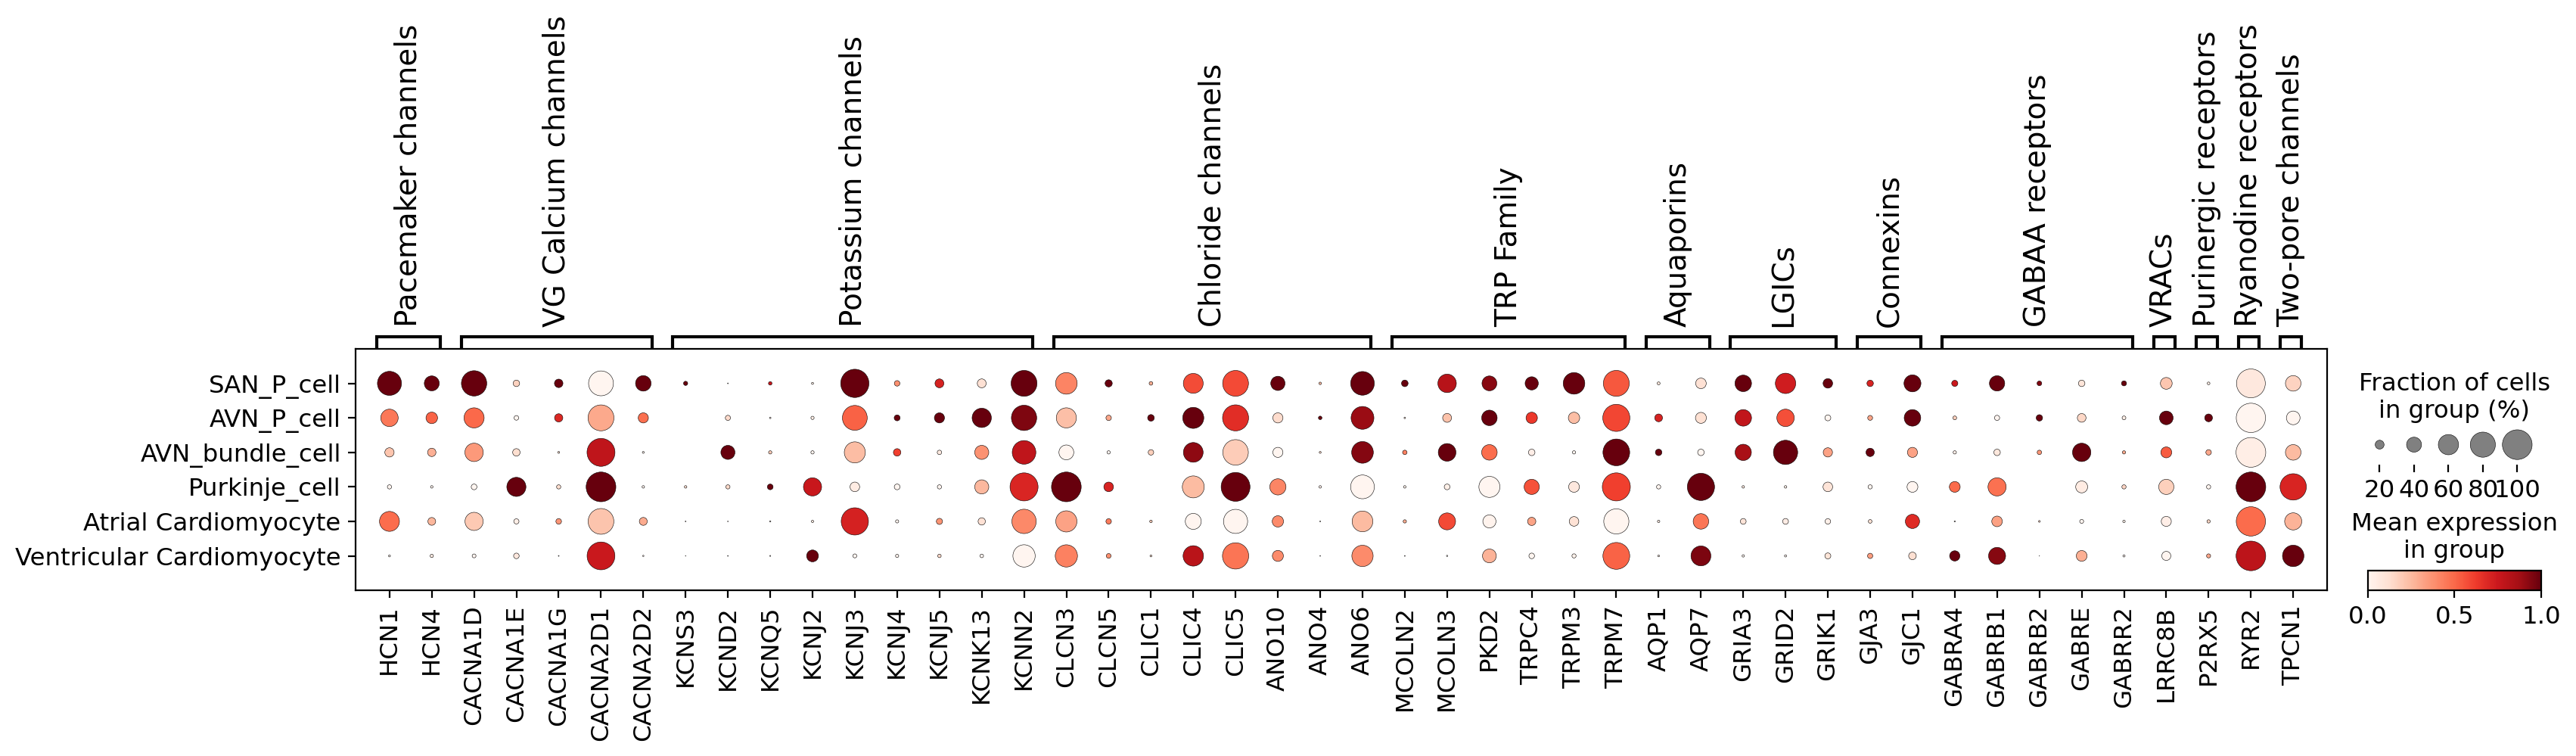

In [57]:
markers_mod = {}
all_keys = list(markers.keys())
for k,v in groups_to_show.items():
    all_keys.remove(k)
    g = markers[k]
    if v not in markers_mod.keys():
        markers_mod[v] = g
    else:
        markers_mod[v] = markers_mod[v] + g
if len(all_keys) > 0:
    print(f'WARNING - there are keys which failed to show: {all_keys}')

sc.pl.dotplot(adata,
              markers_mod, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
              save='Supp_CCS_Ion_Channel_Profile_DEGs.pdf'
             )

In [56]:
# checking the number of genes
for i,k in enumerate(markers_mod.keys()):
    if i==0:
        n = len(markers_mod[k])
    else:
        n = n + len(markers_mod[k])
n

46

## GPCRs

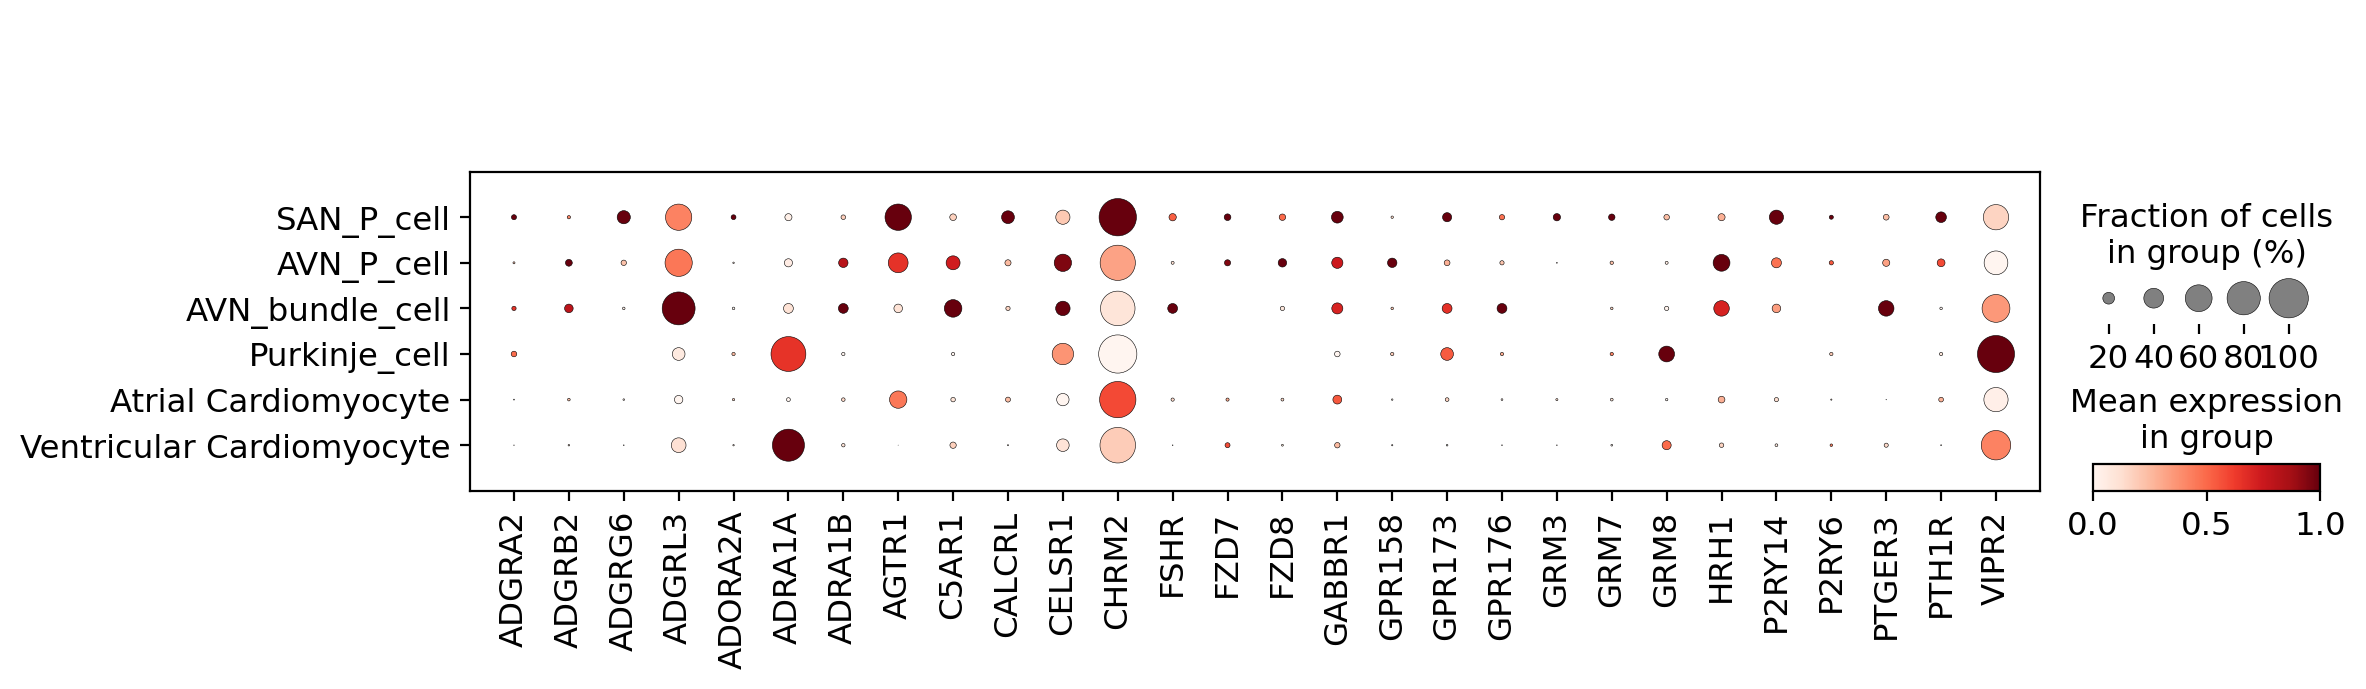

In [82]:
# Plot all DEGs from a HGNC class in one combined dotplot

genes_of_interest=getHGNCgroup(139).symbol.tolist()

genes_for_plotting=DEG_df[(DEG_df.names.isin(genes_of_interest))
       &(DEG_df.logfoldchanges>0)
       &(DEG_df.pvals_adj<0.05)].names.tolist()

genes_for_plotting=sorted(set(genes_for_plotting))

sc.pl.dotplot(adata,
             groupby='cell_type_with_CCS_states',
             var_names=genes_for_plotting,
             standard_scale='var')

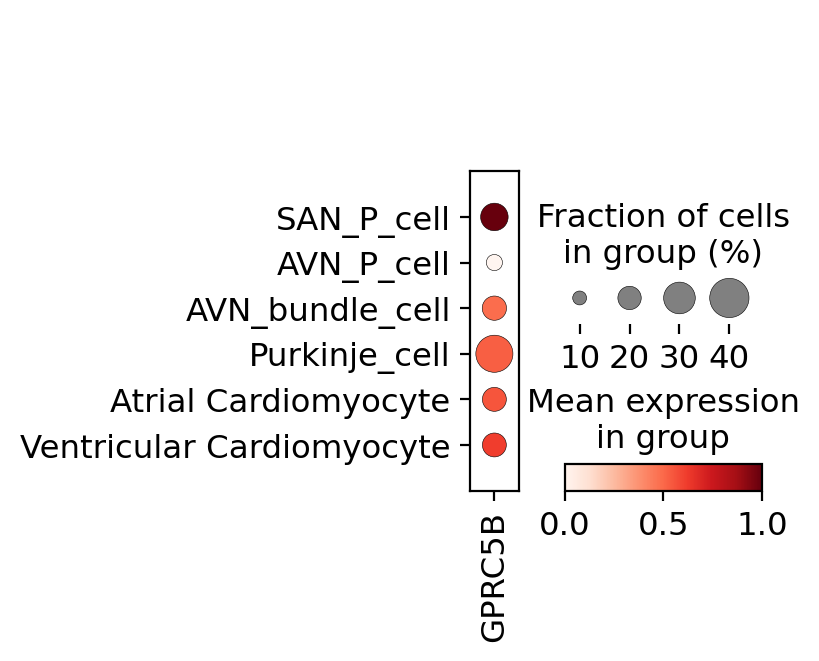

In [88]:
sc.pl.dotplot(adata,
             groupby='cell_type_with_CCS_states',
             var_names='GPRC5B',
             standard_scale='var')

In [59]:
len(genes_for_plotting)

28

In [60]:
# Make into dictionary for a organised plot with dict
gpcrs = read_pkl("/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID139_GPCRs_dict.pkl")
len(gpcrs.keys())

# make a dictionary for group-genes
markers = {}
for k,v in gpcrs.items():
    g =  [x for x in v if x in genes_for_plotting]
    if len(g) > 0:
        markers[k] = g

In [61]:
markers

{'Vasoactive intestinal peptide family receptors ': ['VIPR2'],
 'G protein-coupled receptors, Class A orphans': ['GPR173', 'GPR176'],
 'G protein-coupled receptors, Class C orphans': ['GPR158'],
 'Adenosine receptors': ['ADORA2A'],
 'Adhesion G protein-coupled receptors, subfamily A': ['ADGRA2'],
 'Adhesion G protein-coupled receptors, subfamily B': ['ADGRB2'],
 'Adhesion G protein-coupled receptors, subfamily G': ['ADGRG6'],
 'Adhesion G protein-coupled receptors, subfamily L': ['ADGRL3'],
 'Adrenoceptors': ['ADRA1A', 'ADRA1B'],
 'Angiotensin receptors': ['AGTR1'],
 'Adhesion G protein-coupled receptors, subfamily C': ['CELSR1'],
 'Calcitonin receptors': ['CALCRL'],
 'Cholinergic receptors muscarinic': ['CHRM2'],
 'Complement component GPCRs': ['C5AR1'],
 'Glycoprotein hormone receptors': ['FSHR'],
 'G protein-coupled receptors, Class F frizzled': ['FZD7', 'FZD8'],
 'Gamma-aminobutyric acid type B receptor subunits': ['GABBR1'],
 'Glutamate metabotropic receptors': ['GRM3', 'GRM7', 'G

In [64]:
# rearrange/rename groups based on the genes that appeared
groups_to_show = {
    # 'Adhesion G protein-coupled receptors, subfamily D':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily A':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily B':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily C':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily G':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily L':'Adhesion GPCRs',
    'Adrenoceptors':'Adrenoceptors',
    'Cholinergic receptors muscarinic':'Acetylcholine receptors',
    'Angiotensin receptors':'Angiotensin receptors',
    'Histamine receptors':'Histamine receptors',
    'Glutamate metabotropic receptors':'Glutamate receptors',
    'Calcitonin receptors':'Peptide receptors',
    'Parathyroid hormone receptors':'Peptide receptors',
    'Glycoprotein hormone receptors':'Peptide receptors',
   'Vasoactive intestinal peptide family receptors ':'Peptide receptors',
    'Complement component GPCRs':'Complement receptors',
    # 'Endothelin receptors':'Endothelin receptors',
    'Gamma-aminobutyric acid type B receptor subunits':'GABAB receptors',
    # '5-hydroxytryptamine receptors, G protein-coupled':'Serotonin receptors',
    # 'Lysophosphatidic acid receptors':'LPA receptors',
    'Adenosine receptors':'Adenosine receptors',
    'P2Y receptors':'P2Y receptors',
    'Prostaglandin receptors':'Prostaglandin receptors',
    'G protein-coupled receptors, Class F frizzled':'Frizzled GPCRs',
    'G protein-coupled receptors, Class A orphans':'Orphan GPCRs',
    'G protein-coupled receptors, Class C orphans':'Orphan GPCRs'
}

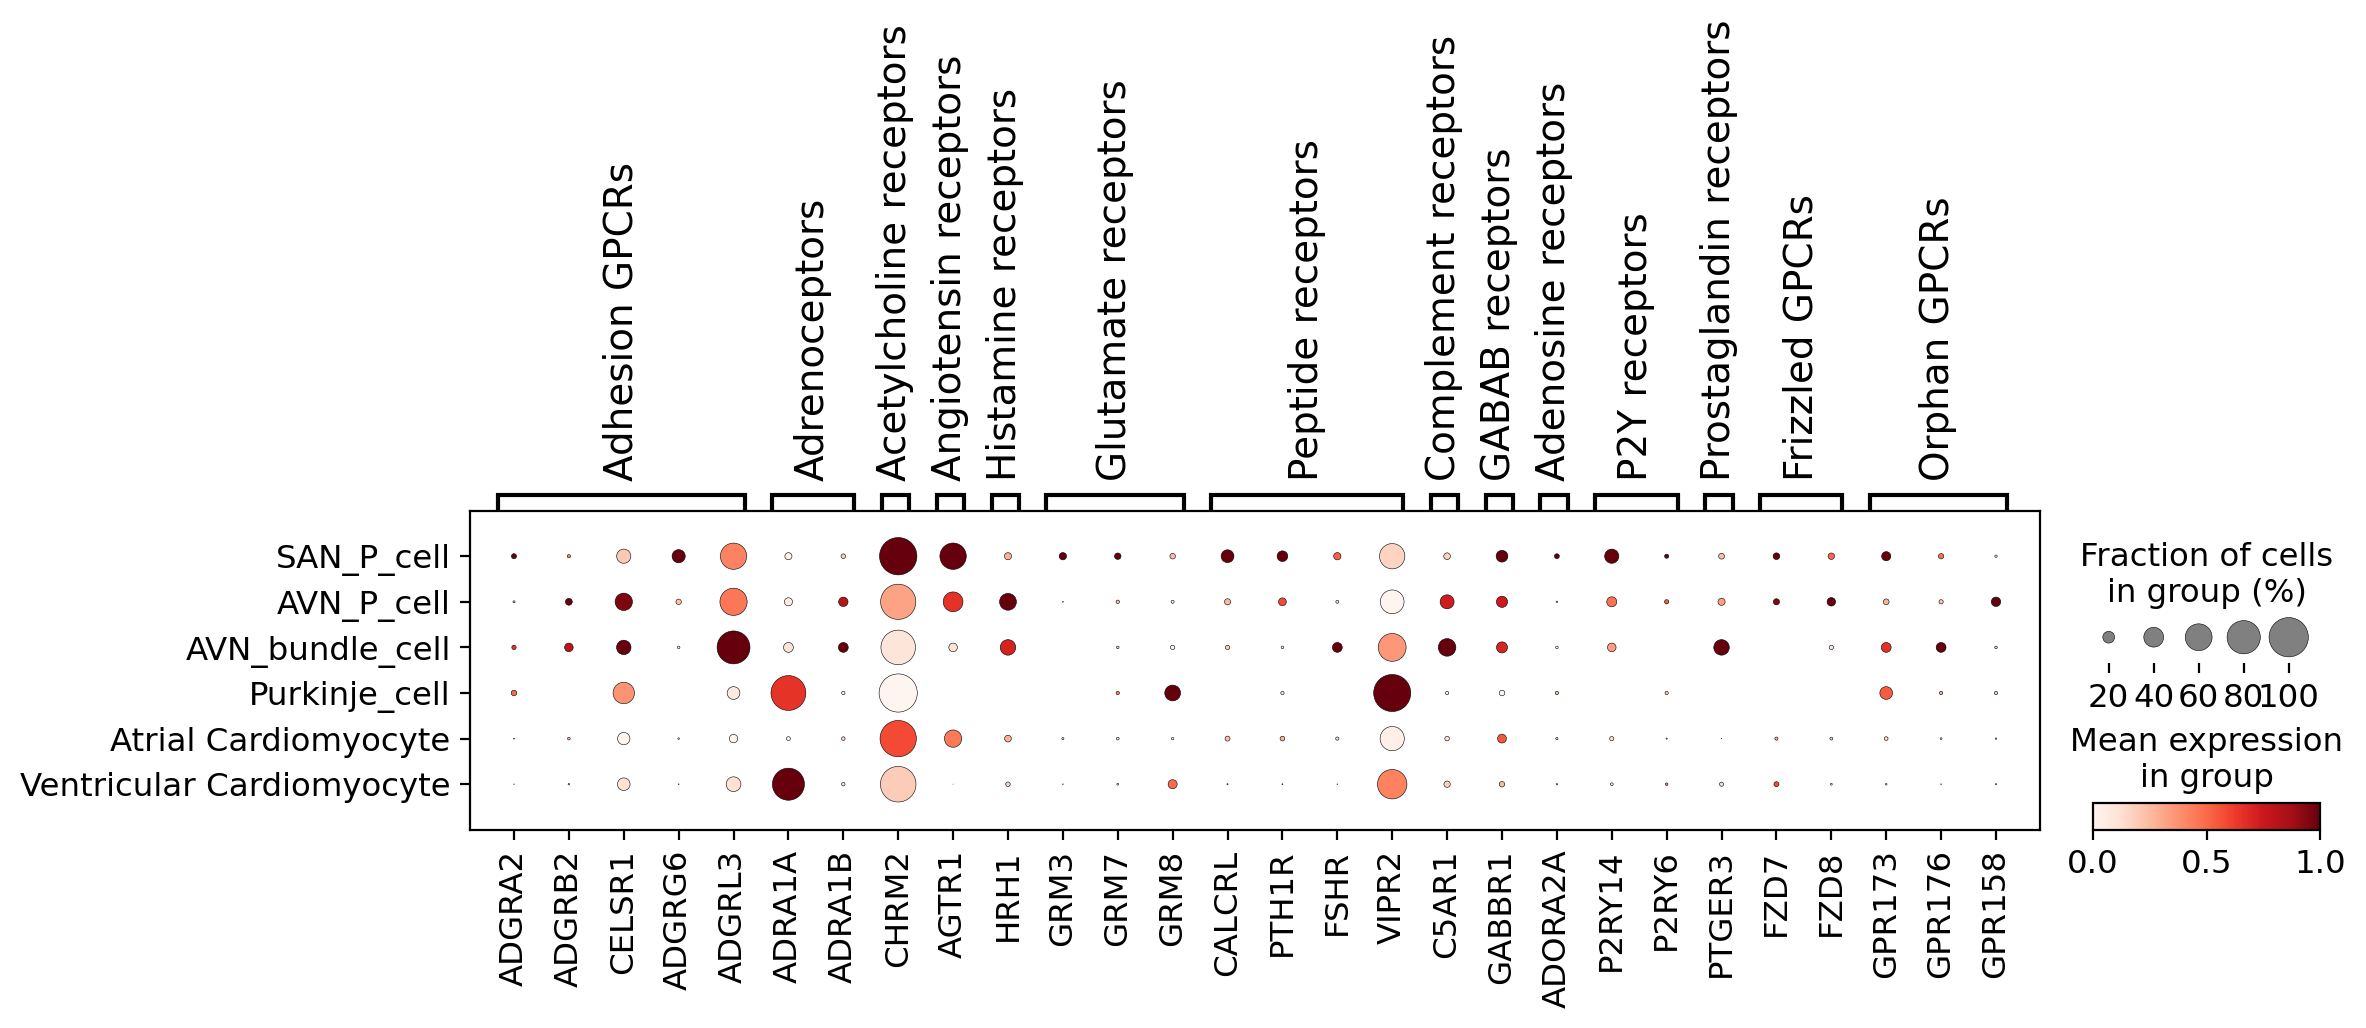

In [66]:
markers_mod = {}
all_keys = list(markers.keys())
for k,v in groups_to_show.items():
    all_keys.remove(k)
    g = markers[k]
    if v not in markers_mod.keys():
        markers_mod[v] = g
    else:
        markers_mod[v] = markers_mod[v] + g
if len(all_keys) > 0:
    print(f'WARNING - there are keys which failed to show: {all_keys}')

sc.pl.dotplot(adata,
              markers_mod, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
              save='Supp_CCS_GPCR_Profile_DEGs.pdf'
             )

In [67]:
# checking the number of genes
for i,k in enumerate(markers_mod.keys()):
    if i==0:
        n = len(markers_mod[k])
    else:
        n = n + len(markers_mod[k])
n

28

## G-protein complexes and Regulators of G-protein signaling

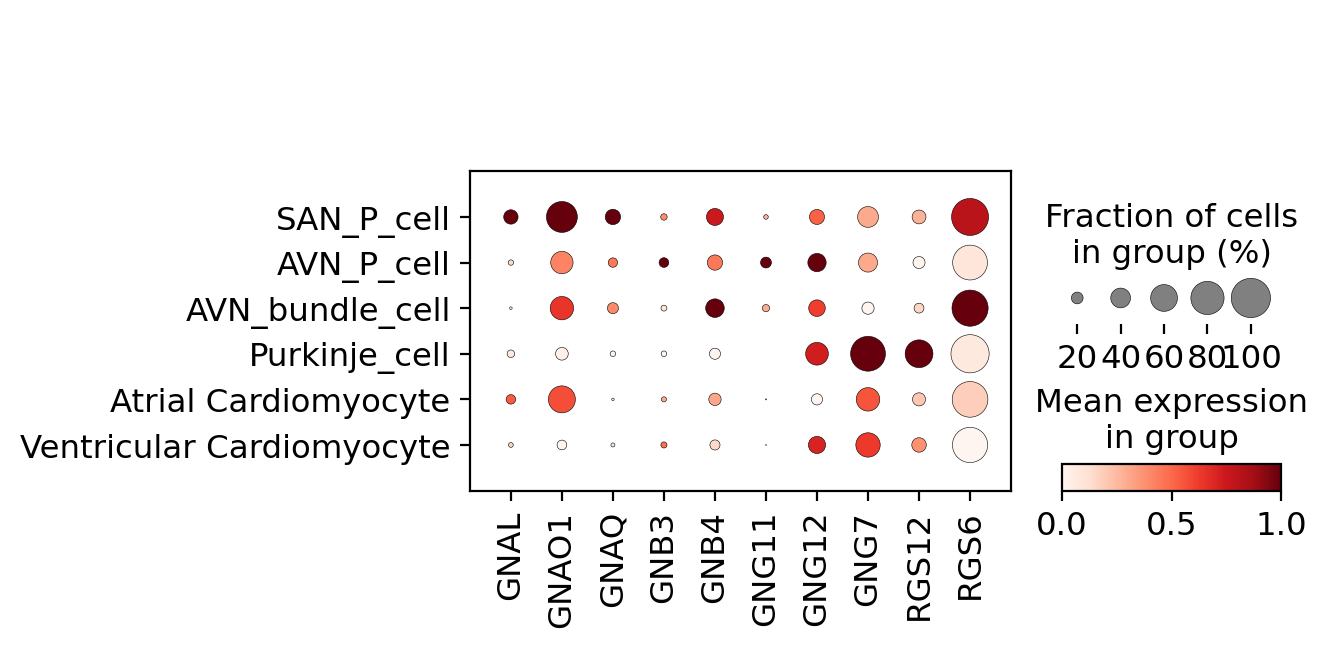

In [84]:
# Plot all DEGs from a HGNC class in one combined dotplot
genes_of_interest=getHGNCgroup(1431).symbol.tolist() + getHGNCgroup(720).symbol.tolist()

genes_for_plotting=DEG_df[(DEG_df.names.isin(genes_of_interest))
       &(DEG_df.logfoldchanges>0)
       &(DEG_df.pvals_adj<0.05)].names.tolist()

genes_for_plotting=sorted(set(genes_for_plotting))

sc.pl.dotplot(adata,
             groupby='cell_type_with_CCS_states',
             var_names=genes_for_plotting,
             standard_scale='var')

In [85]:
genes_for_plotting

['GNAL',
 'GNAO1',
 'GNAQ',
 'GNB3',
 'GNB4',
 'GNG11',
 'GNG12',
 'GNG7',
 'RGS12',
 'RGS6']

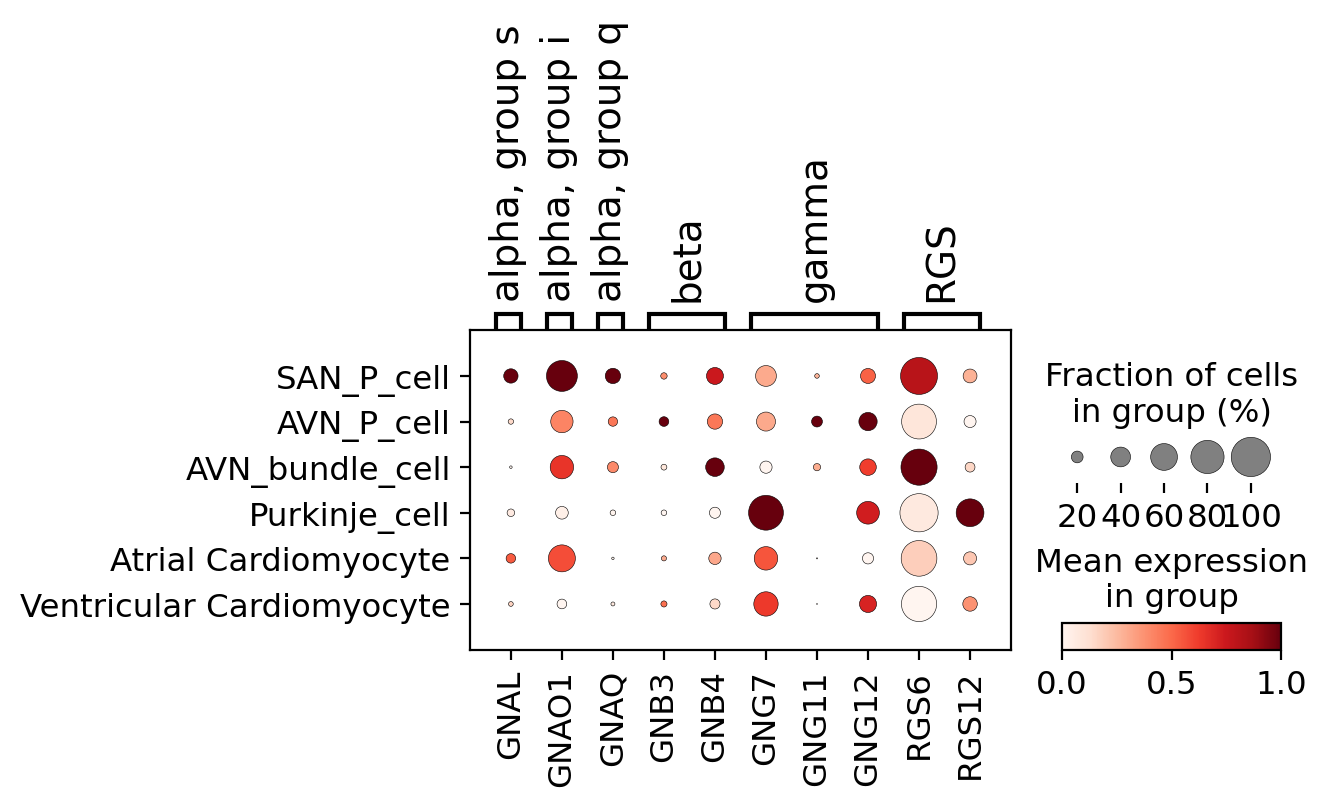

In [69]:
markers={
    'alpha, group s': ['GNAL'],
    'alpha, group i': ['GNAO1'],
    'alpha, group q': ['GNAQ'],
    'beta': ['GNB3','GNB4'],
    'gamma': ['GNG7','GNG11','GNG12'],
    'RGS': ['RGS6','RGS12'],
}

sc.pl.dotplot(adata,
              markers, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
              save='Supp_CCS_Gproteins_Profile_DEGs.pdf'
             )

# Plot expressing genes (but not DEGs)

In [71]:
# get expressing proportion for each gene for each group
exp_prop = get_exp_proportion(adata, groupby='cell_type_with_CCS_states')

In [72]:
# collect exp genes
ccs_exp_genes = list(exp_prop.index[(exp_prop['SAN_P_cell']>0.1)|\
                                    (exp_prop['AVN_P_cell']>0.1)|\
                                    (exp_prop['AVN_bundle_cell']>0.1)|\
                                    (exp_prop['Purkinje_cell']>0.1)])

# collect degs
ccs_degs = list(DEG_df[(DEG_df['logfoldchanges']>0)&(DEG_df['pvals_adj']<0.05)]['names'])

In [91]:
'GPRC5B' in gpcrs

False

## GPCRs

In [73]:
# Make into dictionary for a organised plot with dict
gpcrs = read_pkl("/nfs/team205/kk18/data/geneset/HGNC/HGNC_GID139_GPCRs_dict.pkl")
len(gpcrs.keys())

# make a dictionary for group-genes
markers = {}
for k,v in gpcrs.items():
    g =  [x for x in v if (x in ccs_exp_genes)&(x not in ccs_degs)]
    if len(g) > 0:
        markers[k] = g
        
markers

{'5-hydroxytryptamine receptors, G protein-coupled': ['HTR4'],
 'Atypical chemokine receptors': ['ACKR3', 'ACKR4'],
 'C-X-C motif chemokine receptors': ['CXCR6'],
 'G protein-coupled receptors, Class A orphans': ['GPR135',
  'GPR146',
  'GPR17',
  'GPR18',
  'GPR22',
  'GPR35',
  'GPR52',
  'GPR63',
  'GPR68',
  'LGR4',
  'LGR6'],
 'G protein-coupled receptors, Class C orphans': ['GPRC5B', 'GPRC5C'],
 'Adenosine receptors': ['ADORA1'],
 'Adhesion G protein-coupled receptors, subfamily A': ['ADGRA3'],
 'Adhesion G protein-coupled receptors, subfamily B': ['ADGRB3'],
 'Adhesion G protein-coupled receptors, subfamily D': ['ADGRD1'],
 'Adhesion G protein-coupled receptors, subfamily E': ['ADGRE5'],
 'Adhesion G protein-coupled receptors, subfamily L': ['ADGRL1', 'ADGRL2'],
 'Adhesion G protein-coupled receptors, subfamily V': ['ADGRV1'],
 'Adrenoceptors': ['ADRB1', 'ADRB2'],
 'Cholinergic receptors muscarinic': ['CHRM5'],
 'Endothelin receptors': ['EDNRA'],
 'Glycoprotein hormone receptors

In [77]:
# rearrange/rename groups based on the genes that appeared
groups_to_show = {
    'Adhesion G protein-coupled receptors, subfamily A':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily B':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily D':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily E':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily L':'Adhesion GPCRs',
    'Adhesion G protein-coupled receptors, subfamily V':'Adhesion GPCRs',
    'Adrenoceptors':'Adrenoceptors',
    'Cholinergic receptors muscarinic':'Acetylcholine receptors',
    # 'Angiotensin receptors':'Angiotensin receptors',
    'Histamine receptors':'Histamine receptors',
    'Glutamate metabotropic receptors':'Glutamate receptors',
    'Glucagon receptor family':'Glucagon receptor family',
    # 'Calcitonin receptors':'Peptide receptors',
    # 'Parathyroid hormone receptors':'Peptide receptors',
    'Glycoprotein hormone receptors':'Peptide receptors',
   # 'Vasoactive intestinal peptide family receptors ':'Peptide receptors',
    # 'Complement component GPCRs':'Complement receptors',
    'Neuromedin U receptors':'Peptide receptors',
    'Endothelin receptors':'Endothelin receptors',
    # 'Gamma-aminobutyric acid type B receptor subunits':'GABAB receptors',
    '5-hydroxytryptamine receptors, G protein-coupled':'Serotonin receptors',
    'Lysophosphatidic acid receptors':'LPA receptors',
    'Adenosine receptors':'Adenosine receptors',
    'P2Y receptors':'P2Y receptors',
    'Prostaglandin receptors':'Prostaglandin receptors',
    'Atypical chemokine receptors':'Chemokine receptors',
    'C-X-C motif chemokine receptors':'Chemokine receptors',
    'G protein-coupled receptors, Class F frizzled':'Frizzled GPCRs',
    'Olfactory receptors, family 3':'Olfactory receptors',
    'Opioid receptors':'Opioid receptors',
    'Opsin receptors':'Opsin receptors',
    'Vomeronasal receptors':'Vomeronasal receptors',
    'G protein-coupled receptors, Class A orphans':'Orphan GPCRs',
    'G protein-coupled receptors, Class C orphans':'Orphan GPCRs'
}

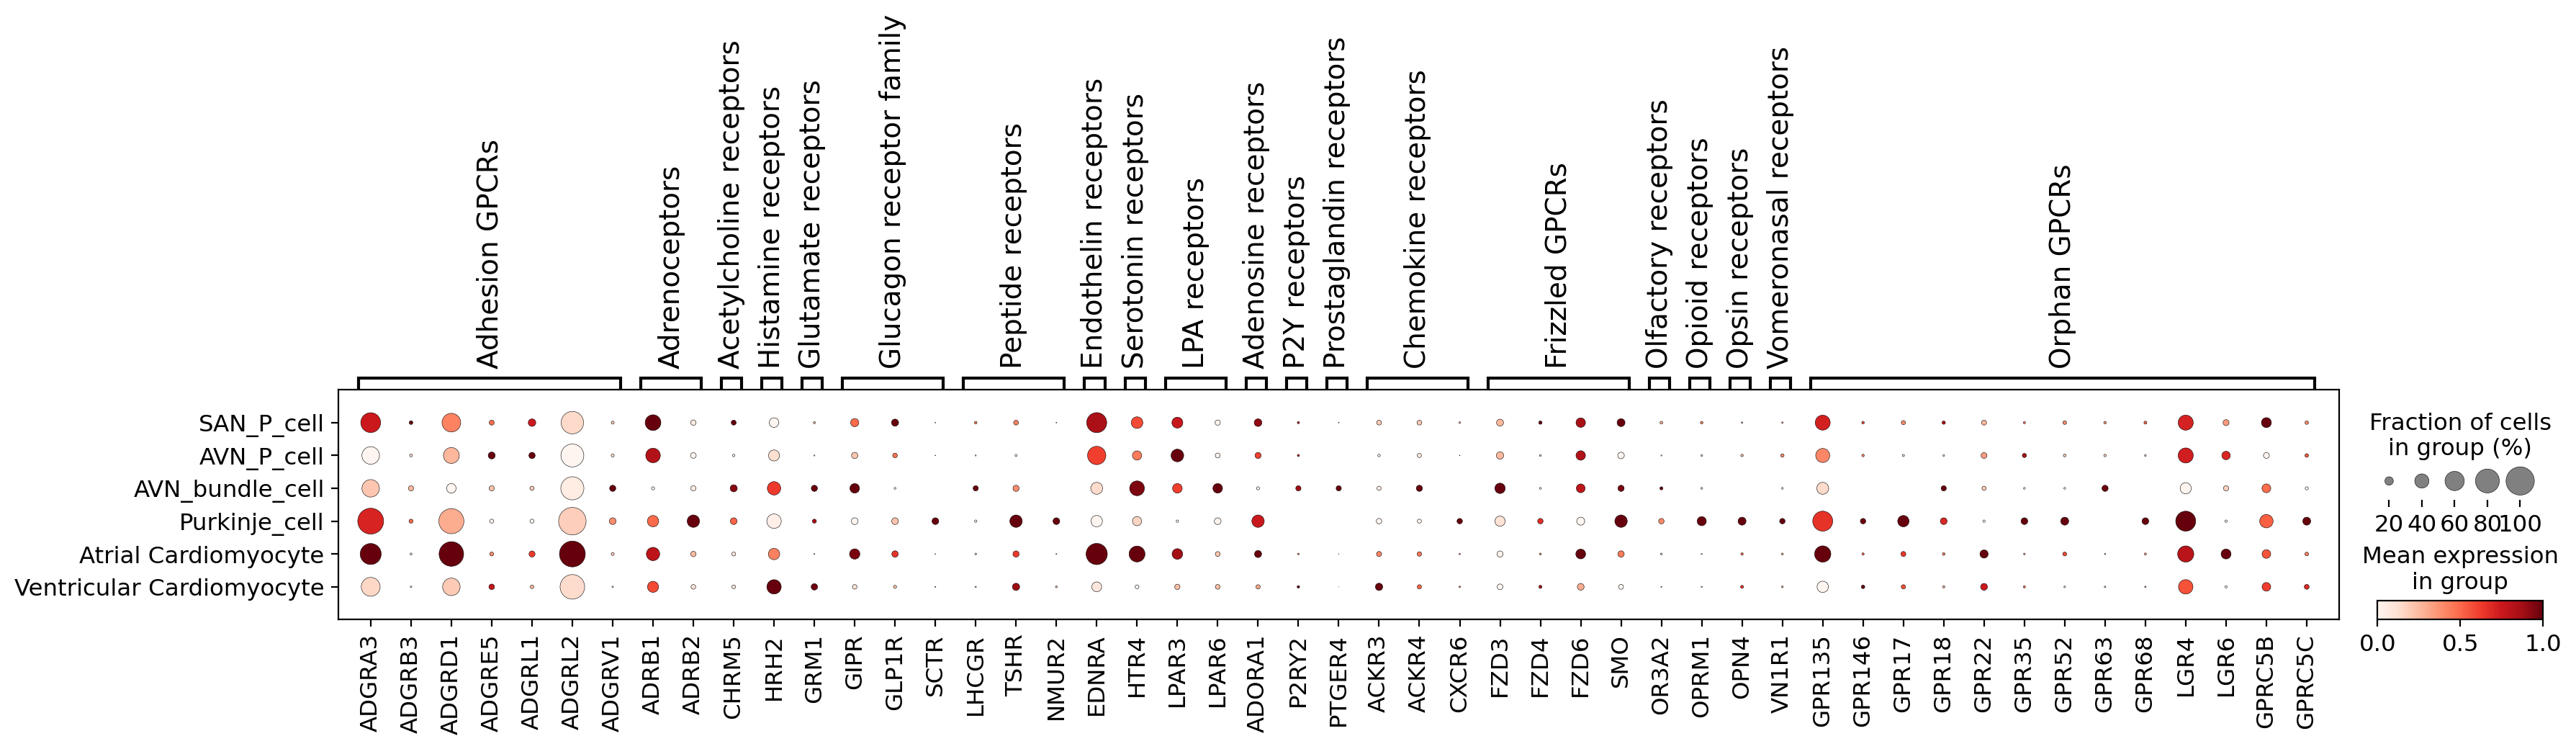

In [78]:
markers_mod = {}
all_keys = list(markers.keys())
for k,v in groups_to_show.items():
    all_keys.remove(k)
    g = markers[k]
    if v not in markers_mod.keys():
        markers_mod[v] = g
    else:
        markers_mod[v] = markers_mod[v] + g
if len(all_keys) > 0:
    print(f'WARNING - there are keys which failed to show: {all_keys}')

sc.pl.dotplot(adata,
              markers_mod, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
             )

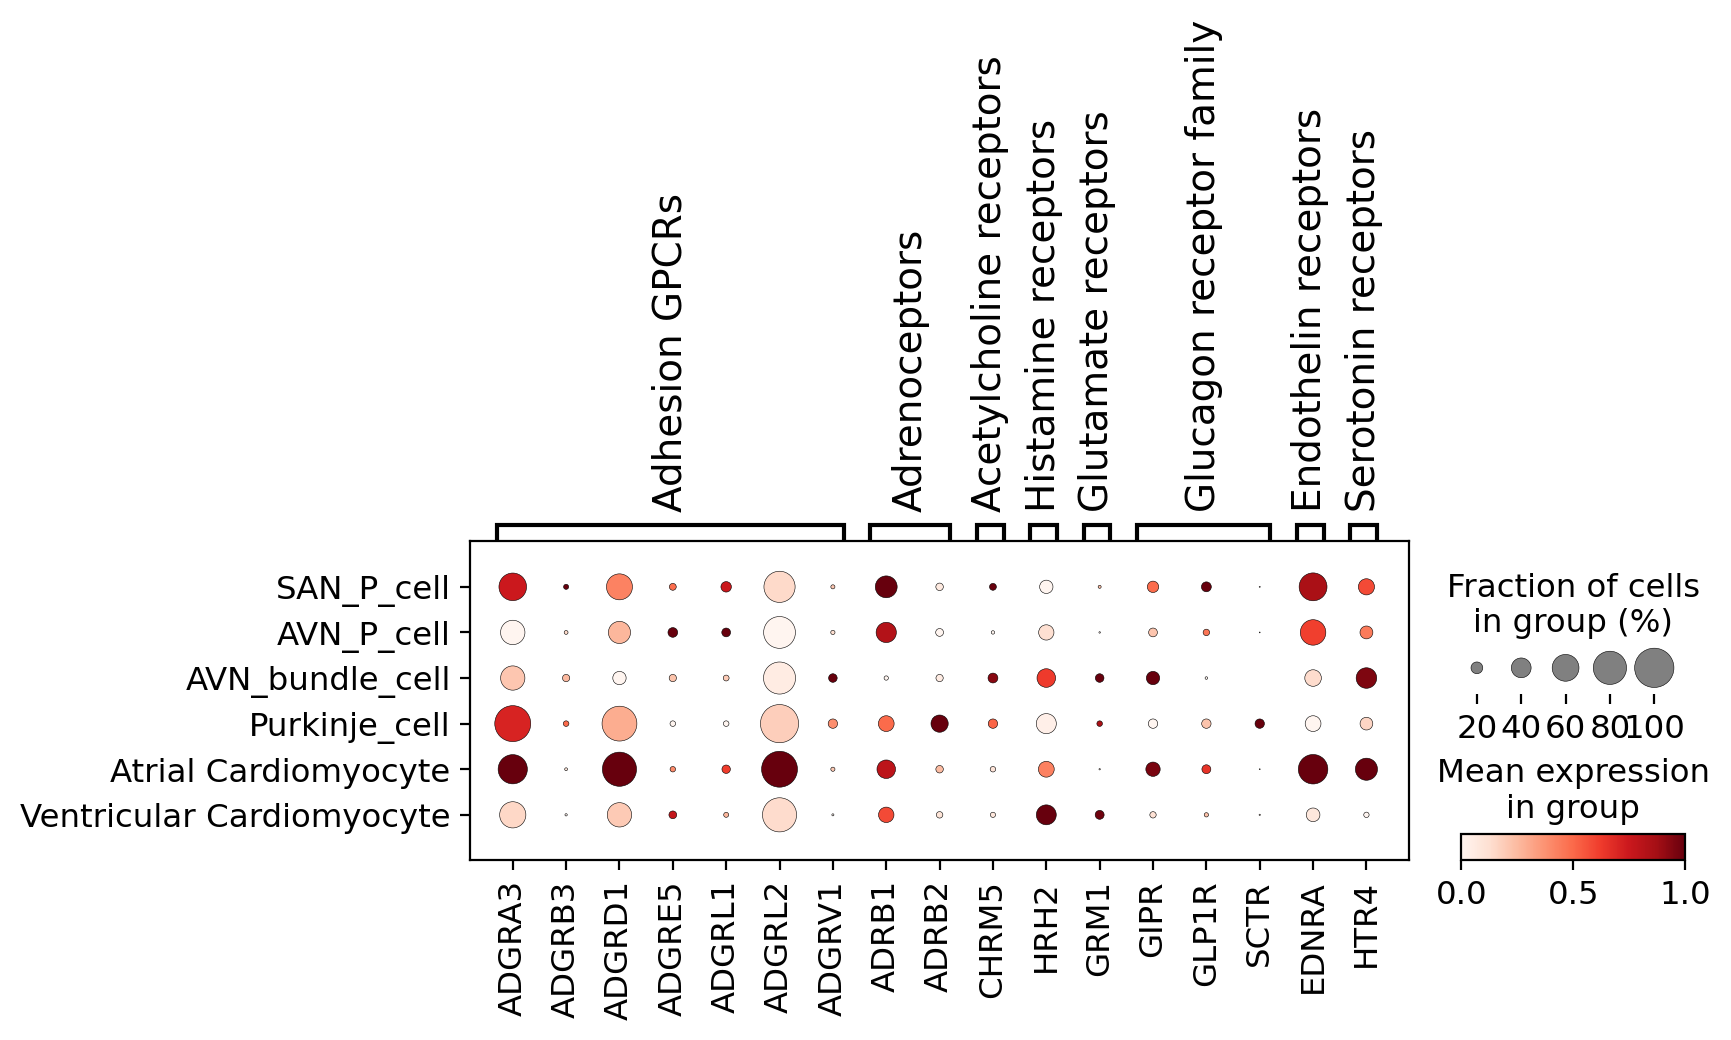

In [79]:
# select category
sc.pl.dotplot(adata,
              {k: markers_mod[k] for k in ['Adhesion GPCRs', 'Adrenoceptors', 'Acetylcholine receptors', 'Histamine receptors', 
                                           'Glutamate receptors', 'Glucagon receptor family',  'Endothelin receptors', 
                                           'Serotonin receptors']}, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
             )

## Gprotein complexes

In [80]:
genes_of_interest=getHGNCgroup(1431).symbol.tolist() + getHGNCgroup(720).symbol.tolist()

genes_of_interest = [x for x in genes_of_interest if (x in ccs_exp_genes)&(x not in ccs_degs)]
genes_of_interest

['GNA11',
 'GNAI1',
 'GNAI2',
 'GNAI3',
 'GNB1',
 'GNB2',
 'GNB5',
 'GNG10',
 'GNG5',
 'GNAS',
 'RGS11',
 'RGS2',
 'RGS3',
 'RGS5',
 'RGS9']

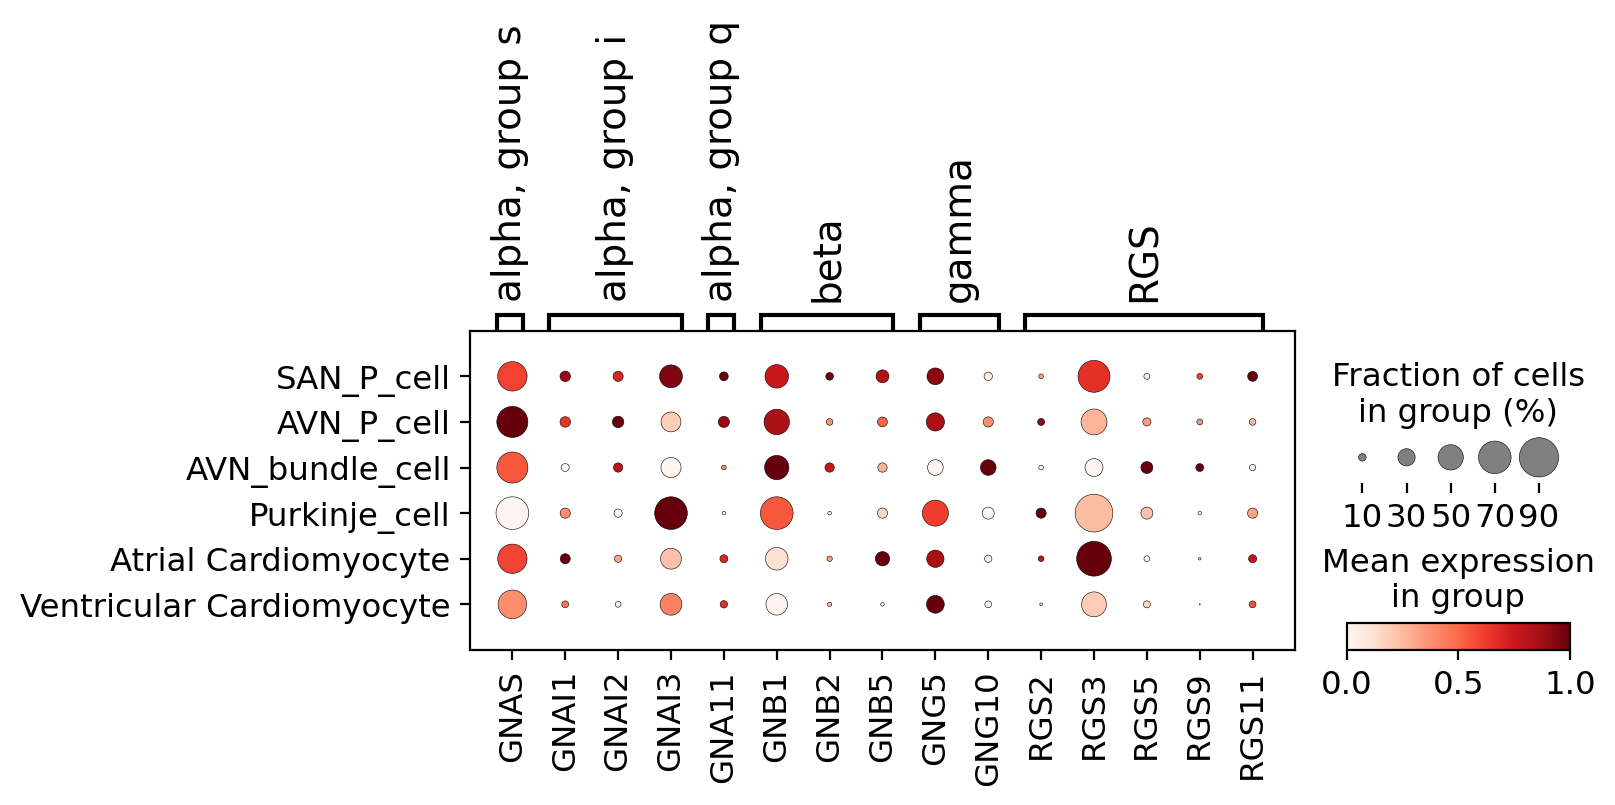

In [81]:
markers={
    'alpha, group s': ['GNAS'],
    'alpha, group i': ['GNAI1',
                         'GNAI2',
                         'GNAI3',],
    'alpha, group q': ['GNA11'],
    'beta': ['GNB1',
             'GNB2',
             'GNB5',],
    'gamma': ['GNG5','GNG10'],
    'RGS': ['RGS2',
             'RGS3',
             'RGS5',
             'RGS9',
           'RGS11'],
}

sc.pl.dotplot(adata,
              markers, 
              groupby='cell_type_with_CCS_states',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
             )

In [96]:
exp_prop.loc[['ADRB1','ADRB2','GLP1R','GNAS','GNB1']]

,SAN_P_cell,AVN_P_cell,AVN_bundle_cell,Purkinje_cell,Atrial Cardiomyocyte,Ventricular Cardiomyocyte
ADRB1,0.457143,0.412903,0.052632,0.296296,0.366901,0.287909
ADRB2,0.110204,0.116129,0.105263,0.333333,0.109785,0.090507
GLP1R,0.159184,0.090323,0.026316,0.148148,0.138195,0.052163
GNAS,0.612245,0.658065,0.657895,0.703704,0.609019,0.588114
GNB1,0.453061,0.503226,0.473684,0.703704,0.429846,0.403943
